In [1]:
import json
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import glob
%matplotlib inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set(rc={'figure.figsize':(9, 3)})
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 600
BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Load MILC data

In [3]:

def lines_that_start_with(string, fp):
    return [line for line in fp if line.startswith(string)]


In [4]:


data = []
for f in glob.glob(os.path.join(BASE_PATH, f'data/baseline/ault/milc_32/milc_*.out')):

    with open(f, 'r') as fp:
        for line in lines_that_start_with("Elapsed total time", fp):
            size = int(f.split('_')[-2])
            data.append([size, float(line.split()[-1])])
            
normal_milc_ault = pd.DataFrame(data=data, columns=['lulesh_size', 'time'])
normal_milc_ault['system'] = 'ault'
normal_milc_ault['type'] = 'baseline'
normal_milc_ault['benchmark'] = 'milc'
normal_milc_ault['application'] = 'milc'
#normal_milc_ault['benchmark-type'] = normal_milc_ault.apply(lambda row: f"({row['benchmark'].upper()}, {row['application'].upper()}, {row['size']})", axis=1)
normal_milc_ault['ranks'] = 32
normal_milc_ault['nodes'] = 1

In [5]:
data = []
for type in ['read', 'write']:

    for pause in [100000, 10000, 1000, 250000, 25000, 500000, 50000, 5000]:

        for f in glob.glob(os.path.join(BASE_PATH, f'data/colocation_rma/milc/{type}_{pause}_10485760/milc_*.out')):

            with open(f, 'r') as fp:
                for line in lines_that_start_with("Elapsed total time", fp):
                    size = int(f.split('_')[-2])
                    data.append([type, pause, size, float(line.split()[-1])])
                
rma_ault = pd.DataFrame(data=data, columns=['type', 'pause', 'lulesh_size', 'time'])
#rma_ault['benchmark-type'] = rma_ault.apply(lambda row: f"({row['type'].capitalize()}, {str(int(row['pause']/1000)).upper()} ms)", axis=1)
rma_ault['benchmark-type'] = rma_ault.apply(lambda row: f"({row['type'].capitalize()[0:1]}, {str(int(row['pause']/1000)).upper()} ms)", axis=1)

rma_ault.sort_values('benchmark-type', inplace=True)


#rma_ault['new-index'] = rma_ault.apply(lambda row: f"({row['type'].capitalize()}, {row['pause']/1000.0})", axis=1)
mean_colocated_lulesh = rma_ault.groupby(['lulesh_size', 'benchmark-type']).mean().reset_index()
median_colocated_lulesh = rma_ault.groupby(['lulesh_size', 'benchmark-type']).median().reset_index()
dev_colocated_lulesh = rma_ault.groupby(['lulesh_size', 'benchmark-type']).std().reset_index()
mean_lulesh = normal_milc_ault.groupby(['lulesh_size']).mean().reset_index()
median_lulesh = normal_milc_ault.groupby(['lulesh_size']).median().reset_index()
dev_lulesh = normal_milc_ault.groupby(['lulesh_size']).std().reset_index()

#print(mean_lulesh)
#print(mean_colocated_lulesh)

df1 = mean_colocated_lulesh.set_index('lulesh_size')
df2 = mean_lulesh.set_index('lulesh_size')
print(df1)
df1['original_time'] = df2['time'].reindex(df1.index)
df1['slowdown'] = df1['time'] / df1['original_time']
df1['original_dev'] = dev_lulesh.set_index('lulesh_size')['time'].reindex(df1.index)
df1['dev'] = dev_colocated_lulesh.set_index('lulesh_size')['time'].reindex(df1.index)
df1['slowdown_dev'] = df1['slowdown']*np.sqrt((df1['original_dev'] / df1['original_time'])**2 + (df1['dev'] / df1['time'])**2)
print(df1)

df1.reset_index(inplace=True)
df1['slowdown'] = (df1['slowdown']-1)*100
df1['slowdown_dev'] = df1['slowdown_dev']*100
from natsort import natsort_keygen


df1.sort_values(['benchmark-type', 'lulesh_size'], inplace=True, key=natsort_keygen())
#df1['new-index'] = df1.apply(lambda row: row['benchmark-type']. f"({row['type'].capitalize()}, {row['pause']/1000.0})", axis=1)

            benchmark-type     pause        time
lulesh_size                                     
32               (R, 1 ms)    1000.0   51.088032
32              (R, 10 ms)   10000.0   50.837041
32             (R, 100 ms)  100000.0   50.628134
32              (R, 25 ms)   25000.0   50.659717
32             (R, 250 ms)  250000.0   50.651601
...                    ...       ...         ...
128             (W, 25 ms)   25000.0  233.407285
128            (W, 250 ms)  250000.0  232.768408
128              (W, 5 ms)    5000.0  235.652554
128             (W, 50 ms)   50000.0  232.532648
128            (W, 500 ms)  500000.0  232.497603

[64 rows x 3 columns]
            benchmark-type     pause        time  original_time  slowdown  \
lulesh_size                                                                 
32               (R, 1 ms)    1000.0   51.088032      50.735378  1.006951   
32              (R, 10 ms)   10000.0   50.837041      50.735378  1.002004   
32             (R, 100 ms)  1000

In [6]:
print(df1)

for index, row in df1.iterrows():
    
    bench = row['benchmark-type']
    bench_type = bench.split(',')[0][1:]
    freq = int(bench.split(',')[1].split(' ')[1])
    
    #print(bench)
    print(f'Type: {bench_type}, reading {1000/freq*10}, size {row["lulesh_size"]}, overhead {row["slowdown"]}')

    lulesh_size benchmark-type     pause        time  original_time  \
0            32      (R, 1 ms)    1000.0   51.088032      50.735378   
16           64      (R, 1 ms)    1000.0  110.544999     105.054064   
32           96      (R, 1 ms)    1000.0  164.833431     150.247961   
48          128      (R, 1 ms)    1000.0  246.973198     217.745631   
5            32      (R, 5 ms)    5000.0   50.781816      50.735378   
..          ...            ...       ...         ...            ...   
60          128    (W, 250 ms)  250000.0  232.768408     217.745631   
15           32    (W, 500 ms)  500000.0   50.586939      50.735378   
31           64    (W, 500 ms)  500000.0  107.054060     105.054064   
47           96    (W, 500 ms)  500000.0  157.969999     150.247961   
63          128    (W, 500 ms)  500000.0  232.497603     217.745631   

     slowdown  original_dev       dev  slowdown_dev  
0    0.695084      0.168378  0.132497      0.424121  
16   5.226771      1.041271  0.150112  

In [7]:
def barplot_err(x, y, xerr=None, yerr=None, data=None, hue=None, **kwargs):

    y_values = []
    yerr_values = []
    for hue_value in data[hue].unique():
        for x_value in data[x].unique():
            row = data.loc[(data[hue] == hue_value) & (data[x] == x_value)]
            y_values.append(row[y].values[0])
            yerr_values.append(row[yerr].values[0])
        
    _ax = sns.barplot(x=x,y=y,data=data, hue=hue, **kwargs)
    
    x_coords = [p.get_x() + 0.5*p.get_width() for p in _ax.patches]
    y_coords = [p.get_height() for p in ax.patches]

    _, caps,_ = _ax.errorbar(x=x_coords, y=y_coords, yerr=yerr_values, linewidth=2, 
                             solid_capstyle='round', solid_joinstyle='round', color='#464646', fmt="none", capsize=2)
    

    for cap in caps:
        cap.set_markeredgewidth(2)
        cap._marker._capstyle = matplotlib._enums.CapStyle.round

    return _ax


In [12]:
df2

,lulesh_size,benchmark-type,pause,time,original_time,slowdown,original_dev,dev,slowdown_dev
0,32,"(R, 1 ms)",1000.0,51.088032,50.735378,0.695084,0.168378,0.132497,0.424121
16,64,"(R, 1 ms)",1000.0,110.544999,105.054064,5.226771,1.041271,0.150112,1.052726
32,96,"(R, 1 ms)",1000.0,164.833431,150.247961,9.707600,2.786965,0.185683,2.038727
48,128,"(R, 1 ms)",1000.0,246.973198,217.745631,13.422803,5.281803,0.328206,2.755395
5,32,"(R, 5 ms)",5000.0,50.781816,50.735378,0.091529,0.168378,0.085662,0.372625
...,...,...,...,...,...,...,...,...,...
60,128,"(W, 250 ms)",250000.0,232.768408,217.745631,6.899232,5.281803,0.520045,2.604004
15,32,"(W, 500 ms)",500000.0,50.586939,50.735378,-0.292576,0.168378,0.170687,0.471890
31,64,"(W, 500 ms)",500000.0,107.054060,105.054064,1.903778,1.041271,0.081421,1.013016
47,96,"(W, 500 ms)",500000.0,157.969999,150.247961,5.139530,2.786965,0.279149,1.959074


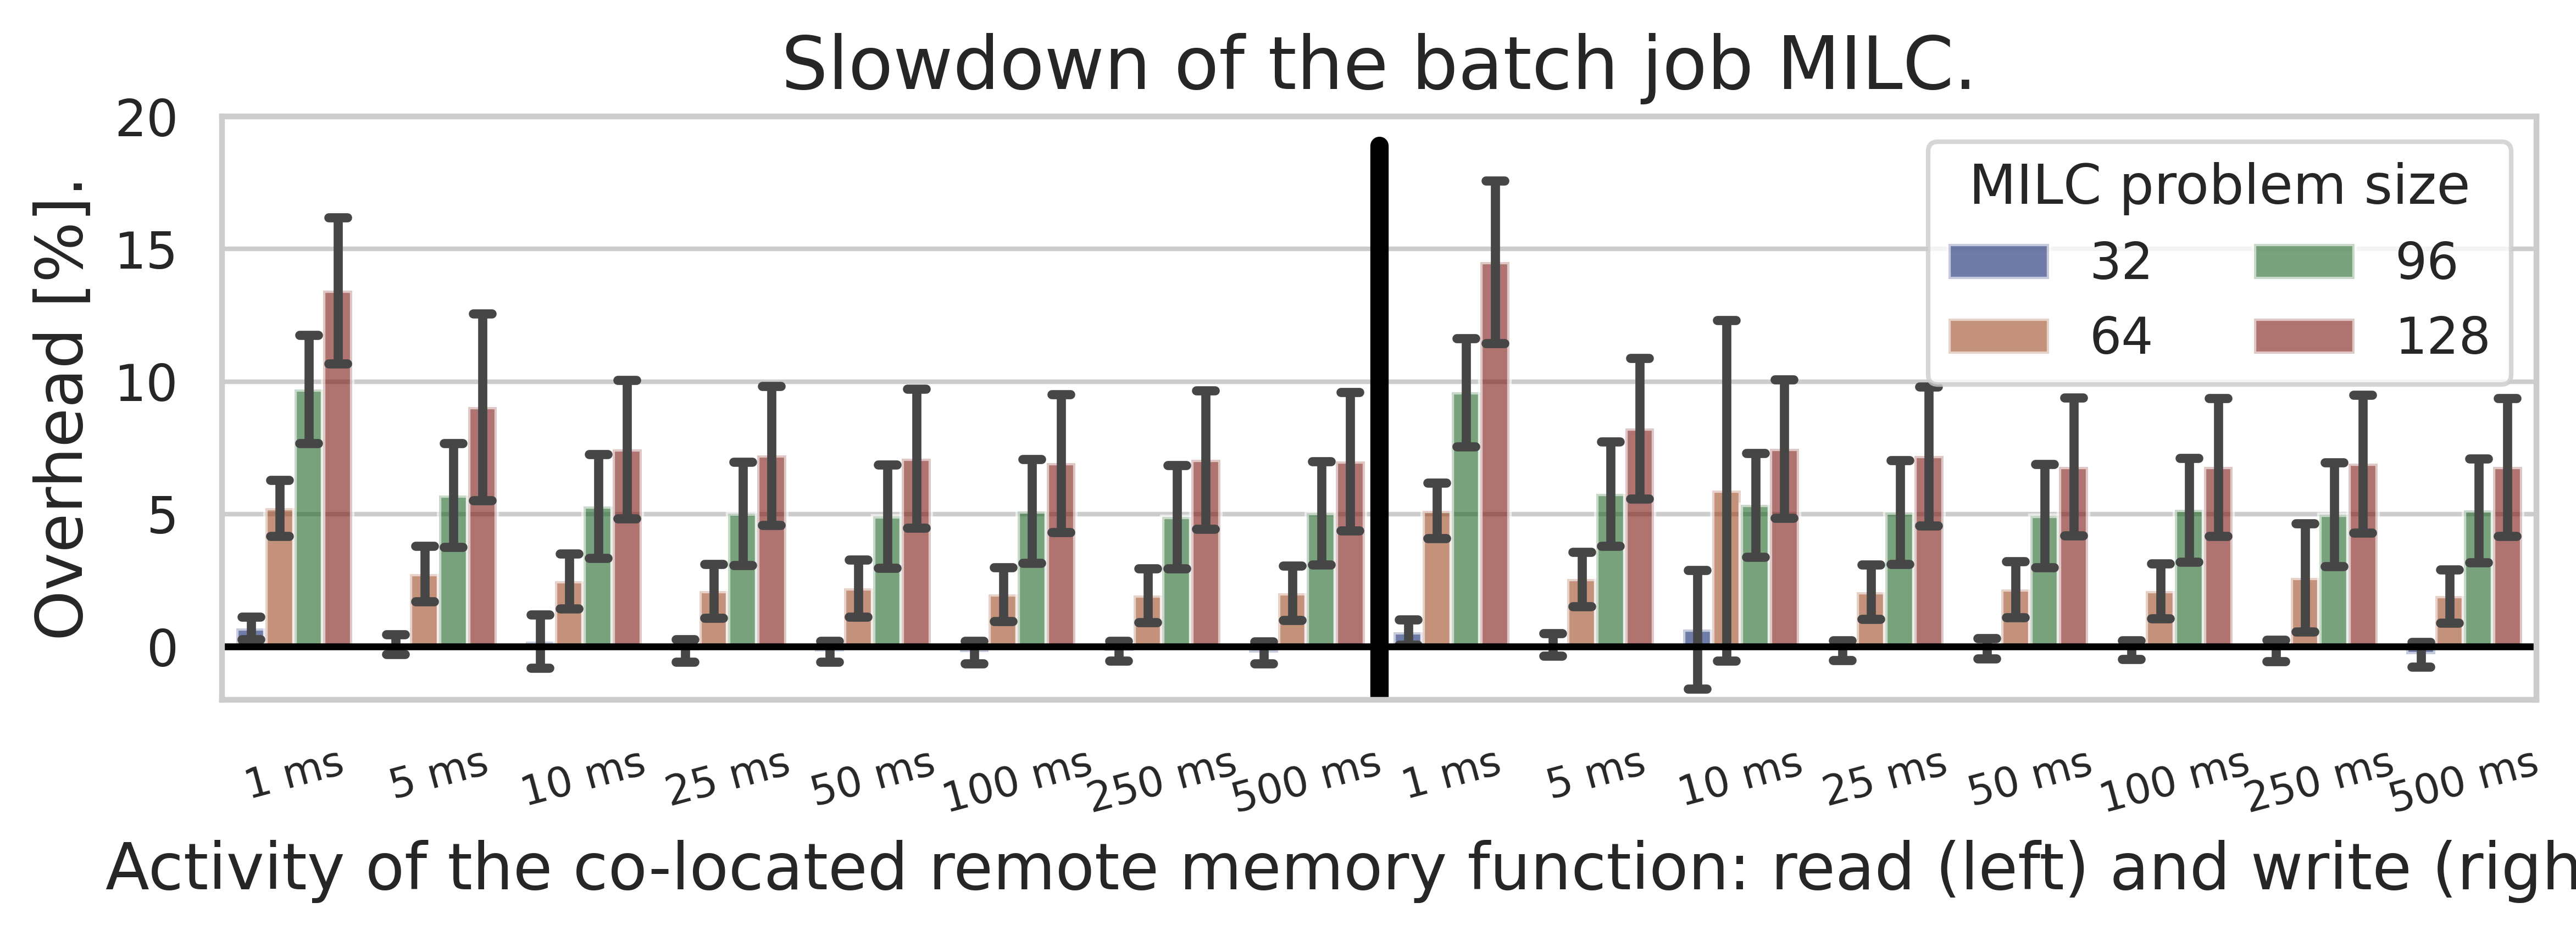

In [11]:

df2 = df1.loc[~(df1['lulesh_size'] == 10)]

sns.set_style("whitegrid")
fig = plt.figure(figsize=(8,3))
ax = fig.gca()
#g = sns.barplot(
#    data=df1.reset_index(),
#    x="type", y="slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #size=.5,#height=6,
#    ax=ax
#)
g = barplot_err(y="slowdown", x="benchmark-type", yerr="slowdown_dev", hue="lulesh_size",
                data=df2,palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Activity of the co-located remote memory function: read (left) and write (right).',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job MILC.',fontsize=16)
g.legend(title='MILC problem size', ncol=2)
g.axhline(y=0, color='black', linestyle='-')
g.set_ylim([-2, 20])
g.set_xlim([-0.5,15.5])

ticks=[]
labels=[]
for tick in g.get_xticklabels():
    ticks.append(tick.get_position()[0])
    labels.append(tick.get_text().split(',')[1][1:-1])
#print(ticks)
#print(labels)
plt.xticks(ticks,labels,fontsize=9, rotation=15)
#plt.xtickslabels(['a'])


#plt.annotate(
#    "Overhead below 7.5% when serving 1 GB/s.",         
#    xytext=(1, 17.5), fontsize=14,       
#    xy=(3, 7)
#)
#plt.annotate(
#    "",         
#    xytext=(4, 17), fontsize=14,       
#    xy=(2.5, 8),
#    arrowprops=dict(facecolor='black', shrink=0.05)
#)
#plt.annotate(
#    "",         
#    xytext=(10, 17), fontsize=14,       
#    xy=(10.25, 10),
#    arrowprops=dict(facecolor='black', shrink=0.05)
#)


plt.axvline(7.5, 0, 0.95, color='black',linewidth=4)
#plt.axvline(7.5, 0,5,color='black',linewidth=4)
#plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig(os.path.join('plots', "colocation_rma_milc.pdf"),bbox_inches='tight',pad_inches = 0, transparent=False)


/tmp/ipykernel_218275/1971246341.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  _ax = sns.barplot(x=x,y=y,data=_data,ci='sd',**kwargs)


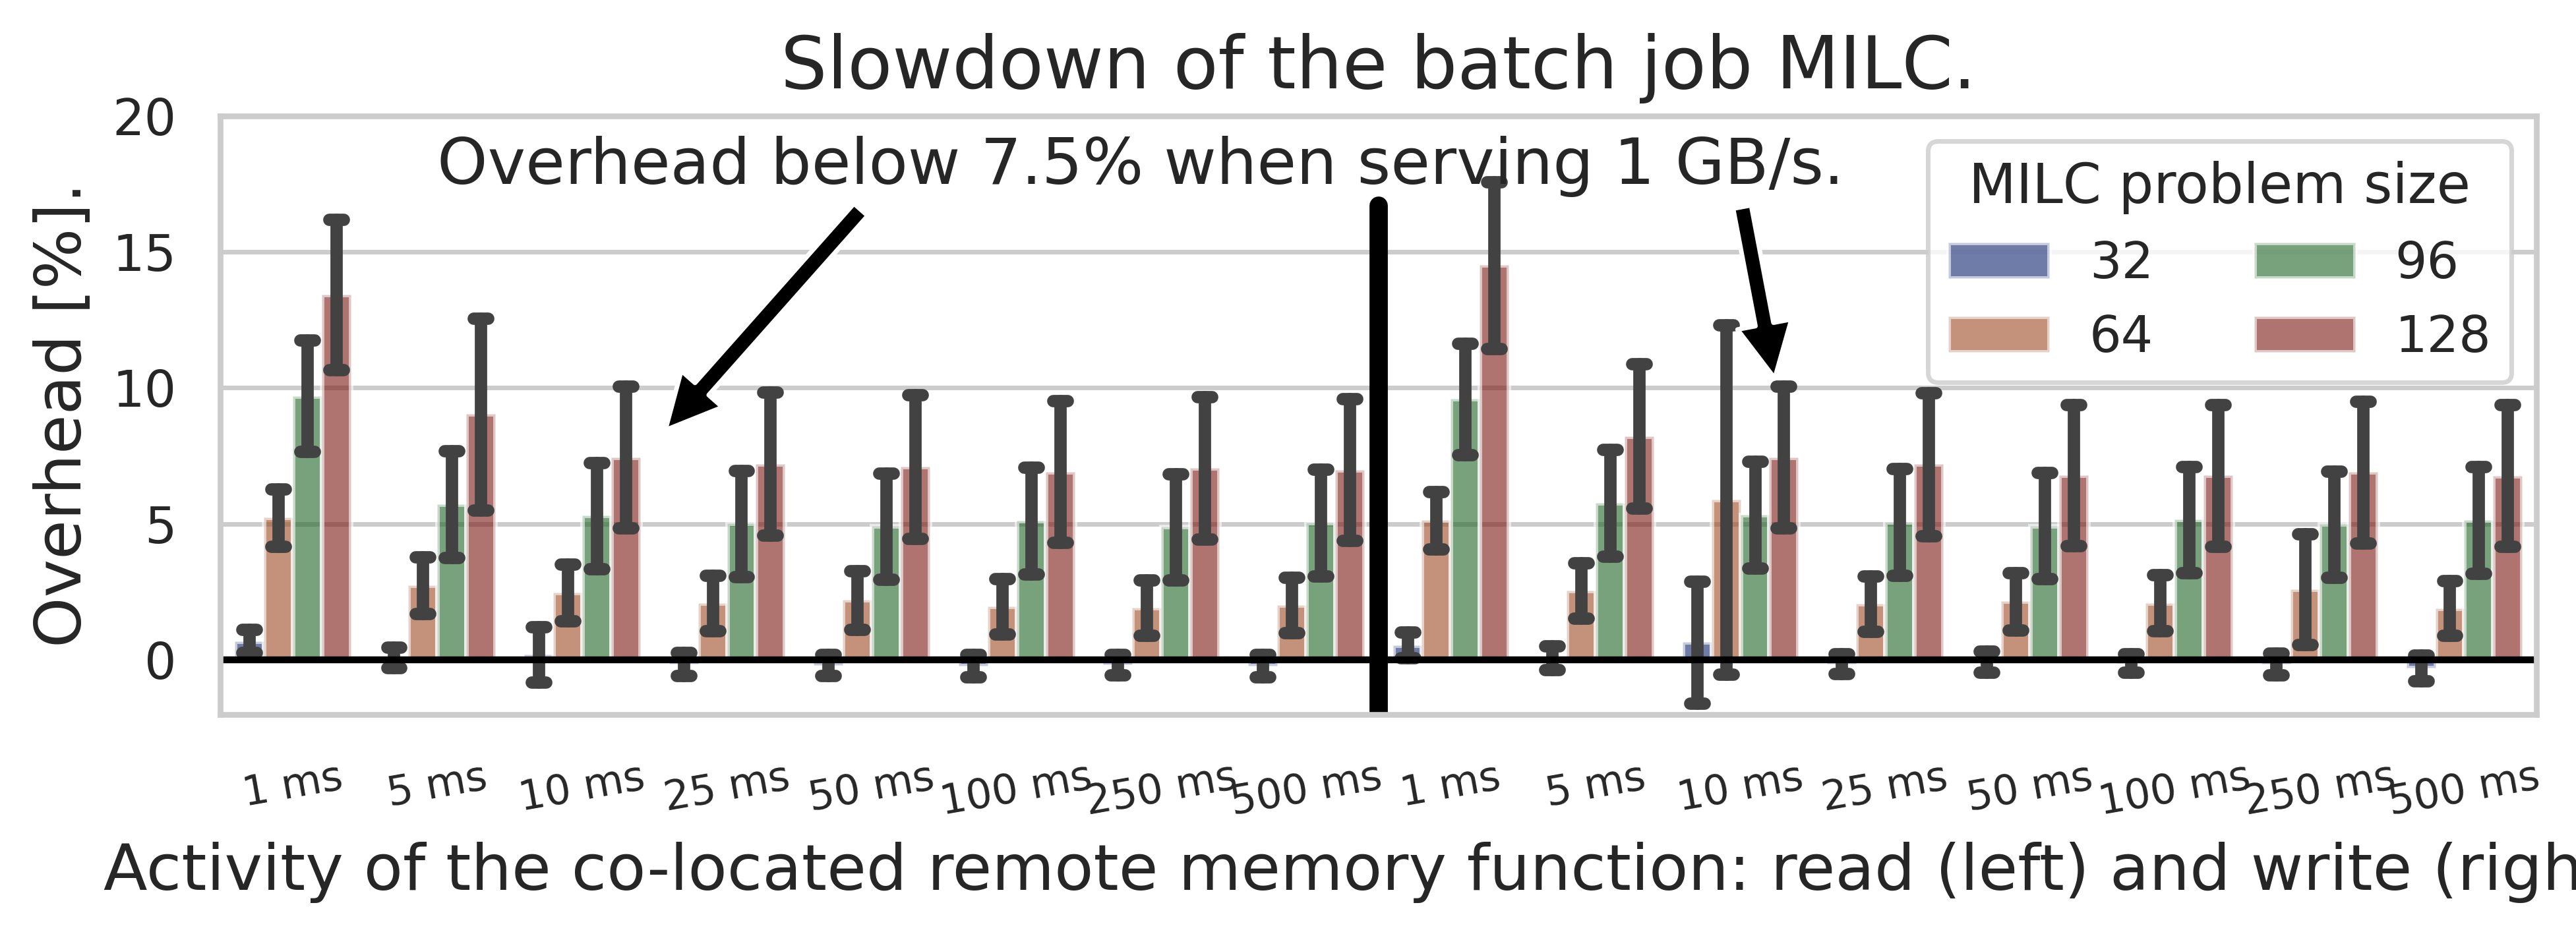

In [55]:

df2 = df1.loc[~(df1['lulesh_size'] == 10)]

sns.set_style("whitegrid")
fig = plt.figure(figsize=(8,3))
ax = fig.gca()
#g = sns.barplot(
#    data=df1.reset_index(),
#    x="type", y="slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #size=.5,#height=6,
#    ax=ax
#)
g = barplot_err(y="slowdown", x="benchmark-type", yerr="slowdown_dev", hue="lulesh_size",
                data=df2,palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Activity of the co-located remote memory function: read (left) and write (right).',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job MILC.',fontsize=16)
g.legend(title='MILC problem size', ncol=2)
g.axhline(y=0, color='black', linestyle='-')
g.set_ylim([-2, 20])

ticks=[]
labels=[]
for tick in g.get_xticklabels():
    ticks.append(tick.get_position()[0])
    labels.append(tick.get_text().split(',')[1][1:-1])
#print(ticks)
#print(labels)
plt.xticks(ticks,labels,fontsize=9, rotation=10)
#plt.xtickslabels(['a'])


plt.annotate(
    "Overhead below 7.5% when serving 1 GB/s.",         
    xytext=(1, 17.5), fontsize=14,       
    xy=(3, 7)
)
plt.annotate(
    "",         
    xytext=(4, 17), fontsize=14,       
    xy=(2.5, 8),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

plt.annotate(
    "",         
    xytext=(10, 17), fontsize=14,       
    xy=(10.25, 10),
    arrowprops=dict(facecolor='black', shrink=0.05)
#             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
#             xy=(1, -2),  #xycoords='data',
#            xytext=(1.5, -3.5), fontsize=14,
#    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)


plt.axvline(7.5, 0, 0.85, color='black',linewidth=4)
#plt.axvline(7.5, 0,5,color='black',linewidth=4)
#plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig(os.path.join('plots', "colocation_rma_milc.pdf"),bbox_inches='tight',pad_inches = 0, transparent=False)

# MILC Plot Poster

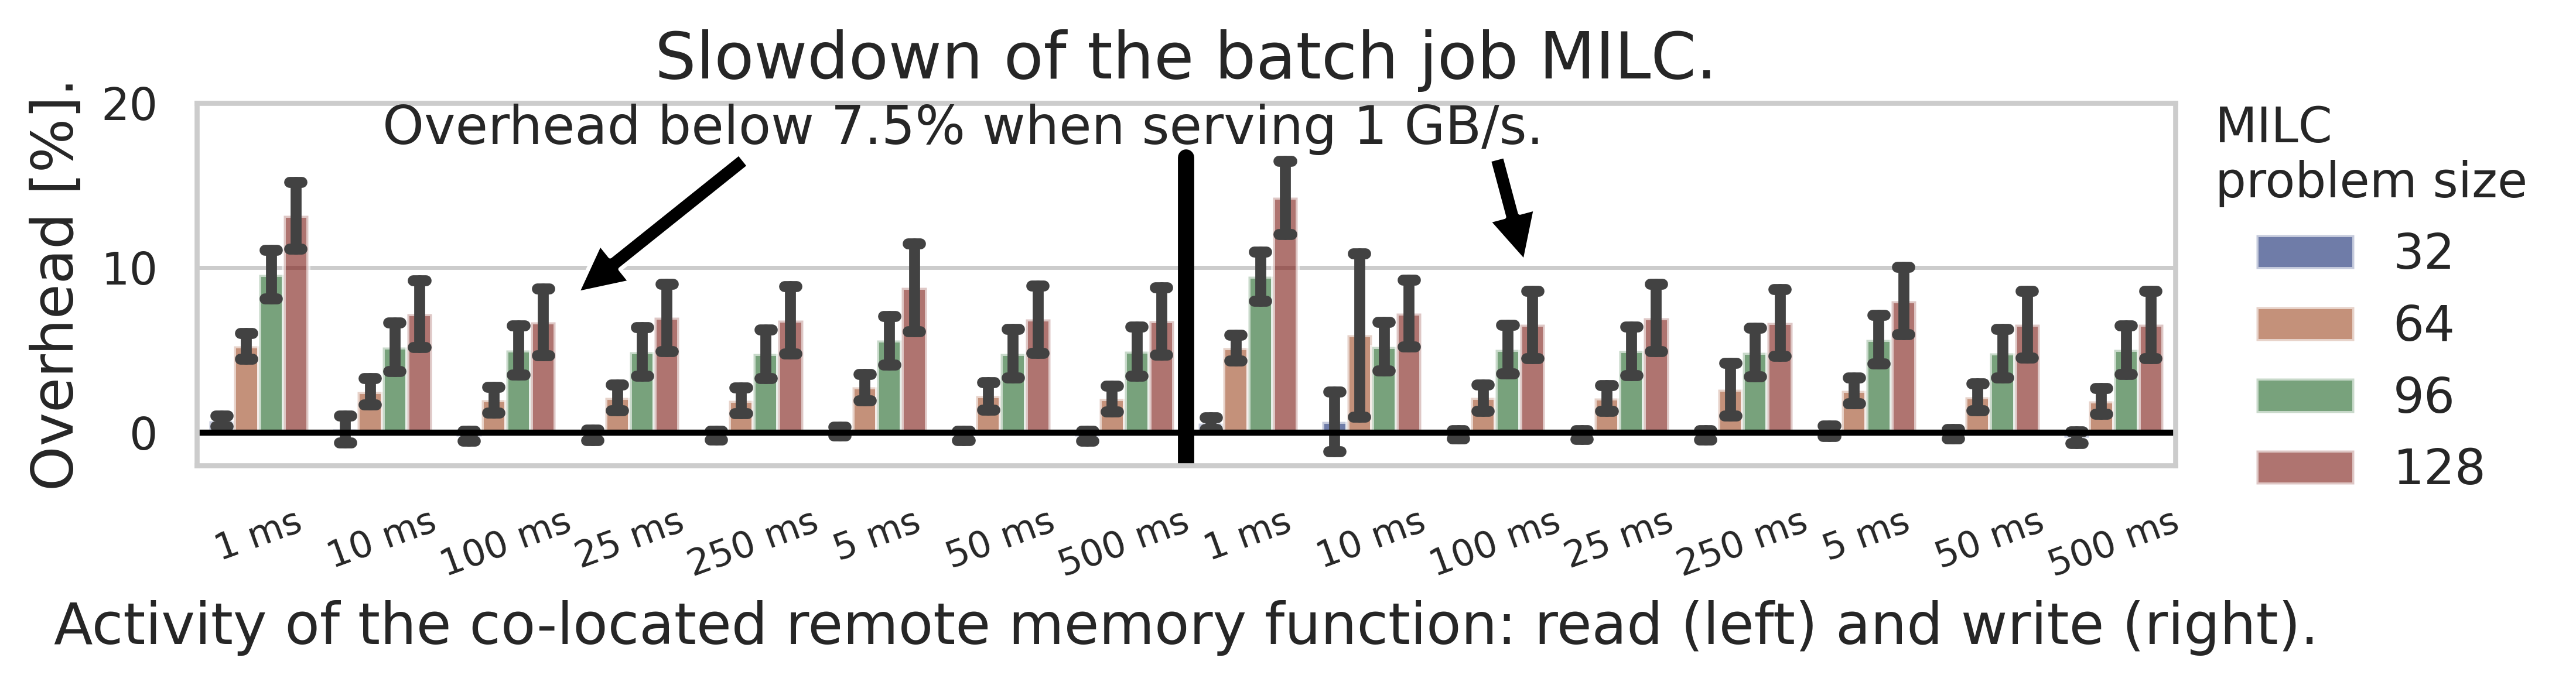

In [11]:

df2 = df1.loc[~(df1['lulesh_size'] == 10)]

sns.set_style("whitegrid")
fig = plt.figure(figsize=(9,2.5))
ax = fig.gca()
#g = sns.barplot(
#    data=df1.reset_index(),
#    x="type", y="slowdown", hue="lulesh_size",
#    ci="sd", palette="dark", alpha=.6, #size=.5,#height=6,
#    ax=ax
#)
g = barplot_err(y="slowdown", x="benchmark-type", yerr="slowdown_dev", hue="lulesh_size",
                data=df2,palette="dark", alpha=.6, capsize=0.1)
g.set_xlabel('Activity of the co-located remote memory function: read (left) and write (right).',fontsize=14)
g.set_ylabel('Overhead [%].',fontsize=14)
g.set_title('Slowdown of the batch job MILC.',fontsize=16)
#g.legend(title='MILC problem size', ncol=2)
g.legend(
    title='MILC\nproblem size',
    fontsize=12,
    ncol=1,
    bbox_to_anchor=(1.2, -0.2),
    loc="lower right",
    frameon=False
)
g.axhline(y=0, color='black', linestyle='-')
g.set_ylim([-2, 20])

ticks=[]
labels=[]
for tick in g.get_xticklabels():
    ticks.append(tick.get_position()[0])
    labels.append(tick.get_text().split(',')[1][1:-1])
#print(ticks)
#print(labels)
plt.xticks(ticks,labels,fontsize=9, rotation=20)
#plt.xtickslabels(['a'])


plt.annotate(
    "Overhead below 7.5% when serving 1 GB/s.",         
    xytext=(1, 17.5), fontsize=13,       
    xy=(3, 7)
)
plt.annotate(
    "",         
    xytext=(4, 17), fontsize=14,       
    xy=(2.5, 8),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

plt.annotate(
    "",         
    xytext=(10, 17), fontsize=14,       
    xy=(10.25, 10),
    arrowprops=dict(facecolor='black', shrink=0.05)
#             #r'Free memory in $\bf{allocated}$'+'\n'+r'and $\bf{idle}$ nodes.',
#             xy=(1, -2),  #xycoords='data',
#            xytext=(1.5, -3.5), fontsize=14,
#    #textcoords='axes fraction',
            #arrowprops=dict(facecolor='black', shrink=0.05)#,horizontalalignment='right'
    #        , verticalalignment='top',
)


plt.axvline(7.5, 0, 0.85, color='black',linewidth=4)
#plt.axvline(7.5, 0,5,color='black',linewidth=4)
#plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig(os.path.join('plots', "colocation_rma_milc_poster.pdf"),bbox_inches='tight',pad_inches = 0, transparent=False)
